In [1]:
import openl3
import soundfile as sf

import sound_utils

import numpy as np

from matplotlib import pyplot as plt
import librosa.display

import IPython.display as ipd

import keras
from keras.layers import Input
from keras.models import Model
import kapre
from kapre.time_frequency import Melspectrogram

%matplotlib inline

Using TensorFlow backend.
/home/prs392/miniconda3/envs/incubator/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/prs392/miniconda3/envs/incubator/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/prs392/miniconda3/envs/incubator/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/pr

In [19]:
audio, sr = sf.read('/scratch/prs392/incubator/data/LibriSpeech/train_clean_360/LibriSpeech/train-clean-360/100/121669/100-121669-0015.flac')

audio.shape, sr

((254800,), 16000)

In [20]:
emb, ts = openl3.get_audio_embedding(audio, sr, center=False)

emb.shape, ts.shape

151/151 [==============================] - 4s 24ms/step


((151, 6144), (151,))

WAV file:  Fs = 16000, x.shape = (254800,), x.dtype = float64


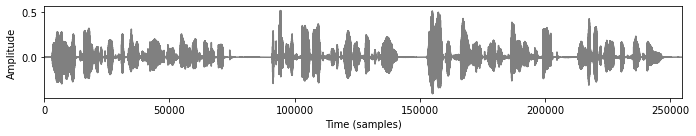

In [4]:
sound_utils.print_plot_play(x=audio, Fs=sr, text='WAV file: ')

In [23]:
audio_sample, start, params = sound_utils.sample_one_second(audio, sr)

WAV file:  Fs = 16000, x.shape = (16000,), x.dtype = float64


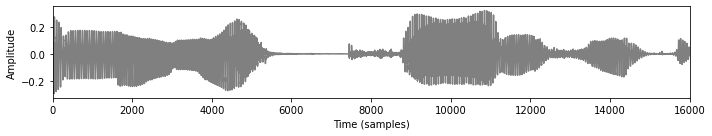

In [24]:
sound_utils.print_plot_play(x=audio_sample, Fs=16000, text='WAV file: ')

In [25]:
emb, ts = openl3.get_audio_embedding(audio_sample, sr, center=False)

1/1 [==============================] - 0s 275ms/step


In [26]:
emb.shape

(1, 6144)

In [27]:
audio_sample.shape

(16000,)

In [28]:
n_fft = 2048
n_mels = 128
n_hop = 242
sr = 16000
audio_window_dur = 1

In [29]:
y = audio_sample

In [43]:
spect = librosa.feature.melspectrogram(y=y, sr = sr, n_mels=n_mels, n_fft=n_fft, hop_length=n_hop, center=True, power=1.0)
spect_dB = librosa.power_to_db(spect, ref=np.max)


In [44]:
spect.shape

(128, 67)

WAV file:  Fs = 16000, x.shape = (15700,), x.dtype = float32


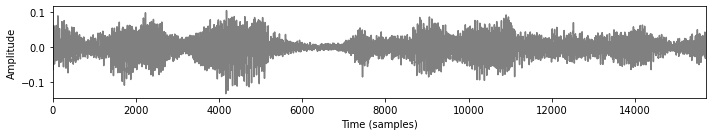

In [45]:
y_audio = librosa.feature.inverse.mel_to_audio(spect, sr = sr, n_fft=n_fft, hop_length=n_hop, center=True, n_iter=100, length=len(y))
# Remove noises at the end
y_audio = y_audio[100:-200]
sound_utils.print_plot_play(x=y_audio, Fs=16000, text='WAV file: ')

In [37]:
audio_window_dur = 1

x_a = Input(shape=(1, sr * audio_window_dur), dtype='float32')

y_a = Melspectrogram(n_dft=n_fft, n_hop=n_hop, n_mels=n_mels,
                  sr=sr, power_melgram=1.0, htk=True, 
                  return_decibel_melgram=False, padding='same')(x_a)
m = Model(inputs=x_a, outputs=y_a)
m.name = 'audio_model'

In [38]:
y_batch = y[np.newaxis, np.newaxis, :]
spect_pred = m.predict(y_batch)
spect_pred = spect_pred[0, :, :, 0]
spect_pred_dB = librosa.power_to_db(spect_pred, ref=np.max)

WAV file:  Fs = 16000, x.shape = (15700,), x.dtype = float32


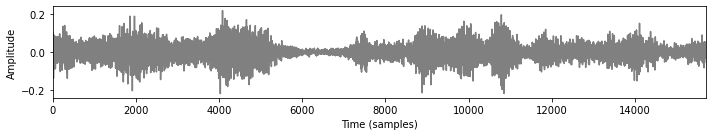

In [39]:
y_audio = librosa.feature.inverse.mel_to_audio(spect_pred, sr = sr, n_fft=n_fft, hop_length=n_hop, center=True, n_iter=100, length=len(y))
# Remove noises at the end
y_audio = y_audio[100:-200]
sound_utils.print_plot_play(x=y_audio, Fs=16000, text='WAV file: ')

In [17]:
spect_dB.shape, spect_pred_dB.shape

((128, 67), (128, 67))

Text(0.5, 1.0, 'log-Spectrogram by Librosa')

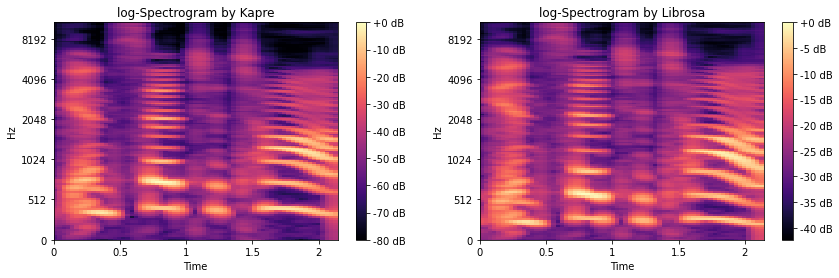

In [18]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.title('log-Spectrogram by Kapre')
librosa.display.specshow(spect_pred_dB, x_axis='time', y_axis='mel', sr=sr)
plt.colorbar(format='%+2.0f dB')

plt.subplot(1, 2, 2)
librosa.display.specshow(spect_dB, x_axis='time', y_axis='mel', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('log-Spectrogram by Librosa')

In [64]:
y_audio = librosa.feature.inverse.mel_to_audio(spect_pred, hop_length=n_hop, center=True, n_iter=100, length=len(y))


In [65]:
y_audio *= 32767 / max (0.01, np.max(np.abs(y_audio)))

WAV file:  Fs = 16000, x.shape = (16000,), x.dtype = float32


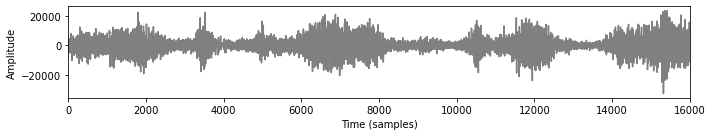

In [66]:
sound_utils.print_plot_play(x=y_audio, Fs=16000, text='WAV file: ')

In [68]:
spect_pred_dB, spect_dB

(array([[-21.904684, -22.48455 , -24.339394, ..., -22.166492, -20.189444,
         -19.603962],
        [-22.349072, -23.270813, -25.702705, ..., -22.444315, -20.299725,
         -19.606186],
        [-21.86081 , -22.590492, -24.694958, ..., -21.509056, -19.91455 ,
         -19.41397 ],
        ...,
        [-31.507278, -31.919632, -33.293434, ..., -31.371868, -29.485992,
         -28.866173],
        [-31.824158, -32.244736, -33.459293, ..., -31.447746, -29.546673,
         -28.919674],
        [-31.497364, -31.832134, -33.043934, ..., -31.588345, -29.624065,
         -28.99189 ]], dtype=float32),
 array([[-39.492416, -40.69886 , -44.68999 , ..., -38.423   , -33.966904,
         -32.45742 ],
        [-39.05229 , -40.266903, -44.281387, ..., -37.511456, -33.55155 ,
         -32.138763],
        [-38.126175, -39.345566, -43.375076, ..., -35.8339  , -32.699272,
         -31.389923],
        ...,
        [-69.63082 , -69.5103  , -69.737595, ..., -70.364365, -68.926605,
         -68.238846

In [47]:
audio.shape

(254800,)

In [62]:
count = 0
temp = audio.shape[0]
# temp = 16000 * 2 + 1700
end = 16000
count += 1
while end < temp:
    end += 0.1 * 16000
    count += 1
count

151

In [61]:
end

256000.0